### Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torchvision.datasets as dataset

from torch.optim import lr_scheduler
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from PIL import Image

import os
import numpy as np
import pandas as pd
import math

In [3]:
from pdb import set_trace
import shutil

### Resizing images

The original images were ~3000x3000. I have resized it to 300x300 for computational efficiency.

In [3]:
# sz = (300,300) #specify the final size

In [4]:
# fn1 = !ls data/normal
# fn2 = !ls data/condition

In [5]:
# for n in fn1:
# #     set_trace()
# #     print(n)
#     im = Image.open(f'data/normal/{n}')
#     im.thumbnail(sz,Image.ANTIALIAS)
#     im.save(f'data/montgomery_china_resized/normal/{n}',format='png')
    

In [6]:
# for n in fn2:
# #     set_trace()
# #     print(n)
#     im = Image.open(f'data/condition/{n}')
#     im.thumbnail(sz,Image.ANTIALIAS)
#     im.save(f'data/montgomery_china_resized/condition/{n}',format='png')

---

We have 800 X-ray images. We have split it into train (680 images) and validation (120 images). 15% validation

### Sample image

In [4]:
path = 'data/'

In [10]:
sample = plt.imread('data/montgomery_china_resized/train/condition/CHNCXR_0329_1.png')

In [11]:
sample.shape

(289, 300, 3)

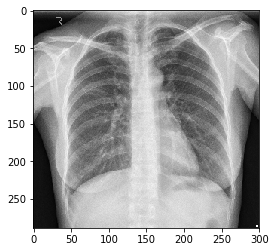

In [12]:
plt.imshow(sample)

In [15]:
sample[:,:,0]

array([[0.6784314 , 0.654902  , 0.6509804 , ..., 0.5294118 , 0.5254902 ,
        0.5529412 ],
       [0.4509804 , 0.4392157 , 0.4862745 , ..., 0.39215687, 0.4       ,
        0.39215687],
       [0.3137255 , 0.36078432, 0.34117648, ..., 0.3137255 , 0.29803923,
        0.27450982],
       ...,
       [0.08235294, 0.09411765, 0.07450981, ..., 1.        , 1.        ,
        0.07450981],
       [0.07843138, 0.07058824, 0.07450981, ..., 1.        , 1.        ,
        0.07843138],
       [0.07450981, 0.07450981, 0.07058824, ..., 0.08235294, 0.07058824,
        0.07450981]], dtype=float32)

---

### Transforms examples

Below are some few kind of transforms that are generally used for data augmentation

In [ ]:
sample = Image.open('data/montgomery_china_resized/train/normal/CHNCXR_0001_0.png')

In [ ]:
plt.imshow(sample) #actual image

#### Center Crop

In [ ]:
t = transforms.CenterCrop(200)
t(sample)

In [ ]:
t = transforms.RandomResizedCrop(256,scale=(1,1))
t(sample)

#### Random Crop

In [ ]:
t = transforms.RandomCrop(200)
t(sample)

In [ ]:
t(sample).size

#### Horizontal Flip

In [ ]:
t = transforms.RandomHorizontalFlip()
t(sample)

#### Vertical Flip

In [ ]:
t = transforms.RandomVerticalFlip()

t(sample)

#### Rotation

In [ ]:
t = transforms.RandomRotation(10)

In [ ]:
t(sample)

### Data structure

In [ ]:
!ls data/montgomery_china_resized/train/normal/ | wc -l #number of normal images in train

In [ ]:
!ls data/montgomery_china_resized/train/condition/ | wc -l #number of condition images in train

In [ ]:
!ls data/montgomery_china_resized/valid/normal/ | wc -l #number of normal images in validation

In [ ]:
!ls data/montgomery_china_resized/valid/condition/ | wc -l #number of condition images in validation

The ratio of each class is roughly the same. I have taken 85% train and 15% validation

### CNN network 1: (Conv2d → maxpool(size=2,stride=2) → RELU)x4→ linear→ logsoftmax

Trying a network without regularization

In [8]:
# CNN Model (4 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.fc1 = nn.Linear(16*16*128, 2)
        self.sm = nn.LogSoftmax(dim = 1)
        
    def forward(self, x):
#         set_trace()
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.sm(out)  
        return out

#### Specifying the hyperparameters

In [9]:
cnn1 = CNN() #instantiating your CNN class
cnn1.cuda() #shifting it to gpu
criterion = nn.NLLLoss() #negative log likelihood as loss function
num_epochs = 10
lr_start = 1e-3
size = 256
batch_size = 64

#### Transformations and dataloader

For now I'm not applying any transforms apart from data pre-processing to make size consistent and normalizing the data.

In [10]:
# Specifying your transforms
transform = transforms.Compose([
    transforms.RandomResizedCrop(size,scale=(1,1)), #Resized images are not exactly of same size so resizing it to make the size constant
    transforms.ToTensor() #normalize the pixels by dividing it by 255
])

This method of data loader is used if we have 2 folders train and validation and there are separate folders for each class within them

In [11]:
#for training
traindir = os.path.join('data/montgomery_china_resized_AHE_3_channel/', 'train')
train = dataset.ImageFolder(traindir, transform=transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True,num_workers=0)

#for validation
valdir = os.path.join('data/montgomery_china_resized_AHE_3_channel/', 'valid')
valid = dataset.ImageFolder(valdir, transform=transform)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False,num_workers=0)

#### Checking dataloader

In [12]:
%%time
xmb,ymb = (iter(train_loader)).next()

CPU times: user 704 ms, sys: 108 ms, total: 812 ms
Wall time: 472 ms


In [13]:
type(xmb)

torch.FloatTensor

In [14]:
xmb.size()

torch.Size([64, 3, 256, 256])

Dataloader is outputing right size of minibatch and image size

### Training and Predict functions

#### Saving model

In [15]:
def save_checkpoint(state,filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    shutil.copyfile(filename, 'model_best.pth.tar')

#### Train

In [46]:
def train(num_epochs,
          train_loader,
          valid_loader,
          cnn,
          criterion,
          batch_size,
          lr_start,
          lr_decay=False,use_checkpoint =  False,checkpoint_file = None,apply_wd = False):
    iterations = 0
    train_loss_tracker = []
    train_accuracy_tracker = []
    val_loss_tracker = []
    val_accuracy_tracker = []
    
    if apply_wd:
        optimizer = torch.optim.Adam(cnn.parameters(), lr=lr_start,weight_decay=1e-4)  #defining the optimizer
    else:
        optimizer = torch.optim.Adam(cnn.parameters(), lr=lr_start)
    if use_checkpoint:
        checkpoint = torch.load(checkpoint_file)
        cnn.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        


    for epoch in range(num_epochs):
        print('Epoch [%d/%d]:' % (epoch + 1, num_epochs))
        print('-----------------')
        print("learning rate:", optimizer.param_groups[0]['lr'])
        if epoch>10:   
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']*.1
        for i, (images, labels) in enumerate(train_loader):
            #  set_trace()
            #minibatch
            images = Variable(images).cuda()  #for gpu
            labels = Variable(labels).cuda()  #for gpu

            # Forward + Backward + Optimize
            optimizer.zero_grad()  #putting all gradients to zero
            outputs = cnn(images)  #forward pass
            loss = criterion(outputs, labels)  #calculating loss
            train_loss_tracker.append(loss)
            loss.backward()  #backward pass to calculate gradients
            optimizer.step()  #updating the network parameters

            iterations += 1
            if (i + 1) % 5 == 0:
                avg_loss = np.mean(train_loss_tracker[-5:])
                print('Average loss of last 5 mini-batches: %.4f' % (avg_loss))
        print('------------')
        train_a = predict(cnn, train_loader)
        train_accuracy_tracker.append(train_a)
        print('Accuracy on training images %.4f' % (train_a))
        val_a, val_l = predict(cnn, valid_loader, False)
        if len(val_loss_tracker)>0 and val_l < min(val_loss_tracker):
            save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': cnn.state_dict(),
            'best_loss_val': val_l,
            'optimizer' : optimizer.state_dict()
        })
        val_loss_tracker.append(val_l)
        val_accuracy_tracker.append(val_a)
        print('Accuracy on test images %.4f' % (val_a))
        print('Loss on test images %.4f' % (val_l))
        print('------------')

#         scheduler.step(val_l)
#         print("learning rate:",optimizer.param_groups[0]['lr'])
    print('-----------Summary--------------')
    print('Number of iterations: %d' % (iterations))
    print('Final avg loss:%.4f' % (np.mean(train_loss_tracker[-5:])))
    val_a, val_l = predict(cnn, valid_loader, False)
    print('Accuracy on test images %.4f' % (val_a))
    print('Loss on test images %.4f' % (val_l))
    print('Minimum loss on test images during the entire training %.4f' % (min(val_loss_tracker)))
    print('Maximum accuracy on test images during the entire training %.4f' % (max(val_accuracy_tracker)))
    return train_loss_tracker,train_accuracy_tracker,val_loss_tracker,val_accuracy_tracker

#### Prediction

In [27]:
def predict(cnn, dataloader,is_train=True):
    cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    val_loss = []
    if is_train:
        #for train
        for images, labels in dataloader:
            images = Variable(images).cuda()
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum()
        accuracy = 100 * correct / total
        return accuracy
    else:
        #for validation
        for images, labels in dataloader:
            images = Variable(images).cuda()
            labels_t = Variable(labels).cuda()
            outputs = cnn(images)
            loss = criterion(outputs, labels_t)
            val_loss.append(loss.data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum()
            images.cpu()
            labels_t.cpu()
        accuracy = 100 * correct / total
        val_loss_avg = np.mean(val_loss)
        
        return accuracy,val_loss_avg       
        

#### Running the model

In [12]:
tl,ta,vl,va = train(10,train_loader,valid_loader,cnn1,criterion,batch_size,1e-3) 

Epoch [1/10]:
-----------------
learning rate: 0.001
Average loss of last 5 mini-batches: 5.4285
Average loss of last 5 mini-batches: 2.7903
------------
Accuracy on training images 50.8824
Accuracy on test images 50.0000
Loss on test images 0.8390
------------
Epoch [2/10]:
-----------------
learning rate: 0.001
Average loss of last 5 mini-batches: 0.8462
Average loss of last 5 mini-batches: 0.7300
------------
Accuracy on training images 65.4412
Accuracy on test images 61.6667
Loss on test images 0.6905
------------
Epoch [3/10]:
-----------------
learning rate: 0.001
Average loss of last 5 mini-batches: 0.7460
Average loss of last 5 mini-batches: 0.6930
------------
Accuracy on training images 49.1176
Accuracy on test images 50.0000
Loss on test images 0.7199
------------
Epoch [4/10]:
-----------------
learning rate: 0.001
Average loss of last 5 mini-batches: 0.6924
Average loss of last 5 mini-batches: 0.6867
------------
Accuracy on training images 67.7941
Accuracy on test images 

This network has been able to overfit the training data. So we have a network which can understand the training data properly. But the problem is that the network is not generalizing very well to the validation data.For that we have to try different regularization techniques.

### CNN network 2: (Conv2d → maxpool(size=2,stride=2) → RELU)x4→Dropout→linear→ logsoftmax

In [18]:
# CNN Model (4 conv layer)
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.layer4 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Dropout(p = 0.2))
        self.fc1 = nn.Linear(16*16*128, 2)
        self.sm = nn.LogSoftmax(dim = 1)
        
    def forward(self, x):
#         set_trace()
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.sm(out)  
        return out

#### Transformations and dataloader

Notice I have applied different transforms for data augmentation this time

In [28]:
# Specifying your transforms
transform1 = transforms.Compose([
    transforms.RandomResizedCrop(size,scale=(.9,1)), #Resized images are not exactly of same size so resizing it to make the size constant
#     transforms.RandomRotation(5),
    transforms.ToTensor() #normalize the pixels by dividing it by 255
])

This method of data loader is used if we have 2 folders train and validation and there are separate folders for each class within them

In [29]:
#for training
traindir = os.path.join('data/montgomery_china_resized_AHE_3_channel/', 'train')
train1 = dataset.ImageFolder(traindir, transform=transform1)
train_loader1 = torch.utils.data.DataLoader(train1, batch_size=batch_size, shuffle=True,num_workers=0)

#for validation
valdir = os.path.join('data/montgomery_china_resized_AHE_3_channel/', 'valid')
valid = dataset.ImageFolder(valdir, transform=transform)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False,num_workers=0)

In [47]:
cnn2 = CNN2()
cnn2.cuda()

CNN2(
  (layer1): Sequential(
    (0): Conv2d (3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d (16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1

In [48]:
tl,ta,vl,va = train(30,train_loader1,valid_loader,cnn2,criterion,batch_size,lr_start=.001) 

Epoch [1/30]:
-----------------
learning rate: 0.001
Average loss of last 5 mini-batches: 2.9512
Average loss of last 5 mini-batches: 2.5189
------------
Accuracy on training images 50.8824
Accuracy on test images 50.0000
Loss on test images 0.9469
------------
Epoch [2/30]:
-----------------
learning rate: 0.001
Average loss of last 5 mini-batches: 0.7986
Average loss of last 5 mini-batches: 0.8169
------------
Accuracy on training images 50.5882
Accuracy on test images 50.0000
Loss on test images 0.6749
------------
Epoch [3/30]:
-----------------
learning rate: 0.001
Average loss of last 5 mini-batches: 0.7214
Average loss of last 5 mini-batches: 0.7009
------------
Accuracy on training images 53.2353
Accuracy on test images 52.5000
Loss on test images 0.6772
------------
Epoch [4/30]:
-----------------
learning rate: 0.001
Average loss of last 5 mini-batches: 0.6306
Average loss of last 5 mini-batches: 0.5756
------------
Accuracy on training images 73.2353
Accuracy on test images 

KeyboardInterrupt: 

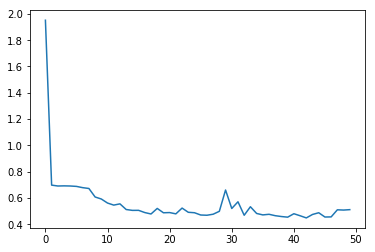

In [24]:
plt.plot(vl)

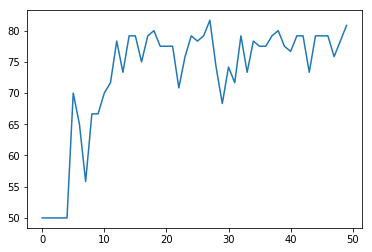

In [25]:
plt.plot(va)

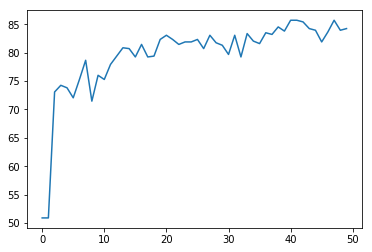

In [216]:
plt.plot(ta)

Training process is saving the best performing state of network. To load this state and continue training follow the below steps:

In [31]:
checkpoint = torch.load('checkpoint.pth.tar')

In [32]:
#loading the state in the network and predicting on the validation
cnn3 = CNN2()
cnn3.cuda()
cnn3.load_state_dict(checkpoint['state_dict'])
predict(cnn3,valid_loader,False)

(79.16666666666667, 0.4445424)

Continue training on this network using lower learning rate

In [210]:
cnn4 = CNN2()

In [211]:
tl,ta,vl,va = train(10,train_loader1,valid_loader,cnn3,criterion,batch_size,1e-4,use_checkpoint=True,checkpoint_file='checkpoint.pth.tar') 

Epoch [1/10]:
-----------------
learning rate: 0.001
Average loss of last 5 mini-batches: 0.4455
Average loss of last 5 mini-batches: 0.4324
------------
Accuracy on training images 84.1176
Accuracy on test images 79.1667
Loss on test images 0.4487
------------
Epoch [2/10]:
-----------------
learning rate: 0.001
Average loss of last 5 mini-batches: 0.3962
Average loss of last 5 mini-batches: 0.4480
------------
Accuracy on training images 78.8235
Accuracy on test images 74.1667
Loss on test images 0.5462
------------
Epoch [3/10]:
-----------------
learning rate: 0.001
Average loss of last 5 mini-batches: 0.4914
Average loss of last 5 mini-batches: 0.4264
------------
Accuracy on training images 81.4706
Accuracy on test images 79.1667
Loss on test images 0.4815
------------
Epoch [4/10]:
-----------------
learning rate: 0.001
Average loss of last 5 mini-batches: 0.4256
Average loss of last 5 mini-batches: 0.4180
------------
Accuracy on training images 81.9118
Accuracy on test images 

In [161]:
checkpoint = torch.load('checkpoint.pth.tar')

In [177]:
#loading the state in the network and predicting on the validation
cnn3 = CNN2()
cnn3.cuda()
cnn3.load_state_dict(checkpoint['state_dict'])
predict(cnn3,valid_loader,False)

(81.66666666666667, 0.4301108)

---

### Finding optimum learning rate

In [ ]:
def lr_finder(lr_start,lr_end,network,min_iterations):
    optimizer = torch.optim.Adam(network.parameters(), lr=lr_start) #defining your optimizer and learning rate from where you want to start
    iter_per_epoch = len(train)//batch_size
    num_epochs = math.ceil(min_iterations/iter_per_epoch)
    iter_total = num_epochs*iter_per_epoch
    
    growth_rate = (lr_end/lr_start)**(1/iter_total)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,gamma = growth_rate,step_size=1)
    
    l = []
    lr = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
    #         images = Variable(images)
            images = Variable(images).cuda() #for gpu
    #         labels = Variable(labels)
            labels = Variable(labels).cuda() #for gpu

            # Forward + Backward + Optimize
            lr.append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.optimizer.zero_grad() #putting all gradients to zero
            outputs = network(images) #forward pass
            loss = criterion(outputs, labels) #calculating loss
            l.append(loss.data[0])
            loss.backward() #backward pass to calculate gradients
            scheduler.step() #updating the network parameters
    
    plt.plot(lr, l)
    return lr,l
    
    

In [ ]:
l1,l2 = lr_finder(1e-5,1e-1,cnn,150)

---